In [1]:
%load_ext jupyter_black

https://pytorch.org/tutorials/beginner/chatbot_tutorial.html?highlight=chatbot#define-evaluation

# Import

In [2]:
from pathlib import Path
import io

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchtext
from torchtext.vocab import build_vocab_from_iterator, GloVe
from nltk.translate import bleu

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
from typing import List

/home/riyadh/codes/nlp/learn2ask/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Look at Data
Data already preprocessed collected from the original repo.

In [3]:
data_root = Path("data/processed")

In [4]:
with open(data_root / "src-train.txt") as f:
    _sentences = f.readlines()

with open(data_root / "tgt-train.txt") as f:
    _questions = f.readlines()

print(len(_sentences), len(_questions))

70484 70484


# Vocabulary

In [5]:
def yield_token(text_file_path):
    with io.open(text_file_path, encoding="utf-8") as f:
        for line in f:
            yield line.strip().split()

In [6]:
%%time
sentence_vocab = build_vocab_from_iterator(
    yield_token(data_root / "src-train.txt"),
    max_tokens=45000,
    specials=["<SOS>", "<EOS>", "<PAD>", "<UNK>"],
    special_first=True,
)

question_vocab = build_vocab_from_iterator(
    yield_token(data_root / "tgt-train.txt"), max_tokens=28000
)

CPU times: user 778 ms, sys: 91.1 ms, total: 869 ms
Wall time: 862 ms


In [7]:
# merge two vocabs once collected from separate corpus
vocab = torchtext.vocab.Vocab(sentence_vocab)
vocab.set_default_index(vocab["<UNK>"])

for token in question_vocab.get_itos():
    if token not in vocab:
        vocab.append_token(token)

print(len(vocab))

49823


In [8]:
embedding_vector = torch.zeros(size=(len(vocab), 300))
glove = GloVe(cache="data/")
for index in range(len(vocab)):
    embedding_vector[index] = glove[vocab.lookup_token(index)]

# Batch Dataloader

In [9]:
config = {"sentence_max_length": 150, "question_max_length": 50, "batch_size": 32}

In [10]:
class SentenceQuestionDataset(Dataset):
    def __init__(
        self,
        vocab: torchtext.vocab.Vocab,
        sentences: List[str],
        questions: List[str],
        Ls=150,
        Lq=50,
    ):
        """
        Represents a dataset of text pairs for training or evaluating models that
        deal with relationships between text passages.

        Args:
            vocab (torchtext.vocab.Vocab): A pre-built vocabulary object
                containing word mappings from text to numerical representation.
            sentences (List[str]): A list of text passages (sentences, paragraphs, etc.).
            questions (List[str]): A list of corresponding questions related to the sentences.
            Ls (int, optional): The maximum length to which sentences will be
                truncated or padded during preprocessing (default: 150).
            Lq (int, optional): The maximum length to which questions will be
                truncated or padded during preprocessing (default: 50).
        """
        self.pad_index = vocab["<PAD>"]
        self.sos_index = vocab["<SOS>"]
        self.eos_index = vocab["<EOS>"]

        sentences_indexed = [vocab(document.split()) for document in sentences]
        questions_indexed = [vocab(document.split()) for document in questions]

        self.sentences_tensor = torch.full(
            (len(sentences), Ls), self.pad_index, dtype=torch.long
        )
        self.questions_tensor = torch.full(
            (len(questions), Lq), self.pad_index, dtype=torch.long
        )

        for i, data in enumerate(zip(sentences_indexed, questions_indexed)):
            # clip sentence length to Ls and add <sos>, <eos>

            _sentence_indices = (
                data[0] if len(data[0]) <= (Ls - 2) else data[0][: (Ls - 2)]
            )
            _sentence_indices = (
                [
                    self.sos_index,
                ]
                + _sentence_indices
                + [
                    self.eos_index,
                ]
            )
            ls = len(_sentence_indices)
            self.sentences_tensor[i, :ls] = torch.tensor(_sentence_indices)

            # clip question length to Lq and add <sos>, <eos>
            _question_indices = (
                data[1] if len(data[1]) <= (Lq - 2) else data[1][: (Lq - 2)]
            )
            _question_indices = (
                [
                    self.sos_index,
                ]
                + _question_indices
                + [
                    self.eos_index,
                ]
            )
            # lq may or may not be equal to Lq
            lq = len(_question_indices)
            self.questions_tensor[i, :lq] = torch.tensor(_question_indices)

    def __len__(self):
        return self.sentences_tensor.size(0)

    def __getitem__(self, index):
        return (self.sentences_tensor[index], self.questions_tensor[index])


train_ds = SentenceQuestionDataset(
    vocab,
    _sentences,
    _questions,
    Ls=config["sentence_max_length"],
    Lq=config["question_max_length"],
)

In [11]:
train_dl = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
print(len(train_dl))

2203


# Models

## Encoder

In [12]:
class Encoder(nn.Module):
    def __init__(
        self, vocab_size, embedding, embedding_dim, hidden_dim=8, bidirectional=False
    ):
        super().__init__()
        self.embedding = embedding
        self.encoder = nn.Sequential(
            self.embedding,
            nn.LSTM(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                batch_first=True,
                bidirectional=bidirectional,
            ),
        )

    def forward(self, src: torch.Tensor):
        """
        Args:
            src (torch.Tensor): (N, Ls) A batch of source sentences represented as tensors.
        """
        # encoder_representation (N, Ls, d), hT => cT => (#direction * #layer, N, d) : hidden states from the last timestep
        encoder_out, (last_hidden_state, last_cell_state) = self.encoder(src)
        return encoder_out, (last_hidden_state, last_cell_state)

In [13]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ["dot", "general", "concat"]:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == "general":
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == "concat":
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(
            torch.cat(
                (hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2
            )
        ).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == "general":
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == "concat":
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == "dot":
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        # attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return nn.functional.softmax(attn_energies, dim=1).unsqueeze(1)

In [25]:
from globalattention import Attention

In [46]:
class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding,
        embedding_dim,
        hidden_dim=8,
        encoder_bidirectional=False,
        num_layers=1,
    ):
        super().__init__()
        self.embedding = embedding
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=False,
            num_layers=num_layers,
        )

        # self.attn_layer = nn.Linear(
        #     in_features=hidden_dim * 2 if bidirectional else hidden_dim,
        #     out_features=hidden_dim * 2 if bidirectional else hidden_dim,
        # )

        self.attention = Attention(
            hidden_dim * 2 if encoder_bidirectional else hidden_dim, hidden_dim
        )

        self.decoder_linear = nn.Sequential(
            # 3*hidden_dim because decoder_out and source context will be concatenated
            # this layer is Eq 5 in the Luong et. al. paper
            nn.Linear(
                hidden_dim * 3 if encoder_bidirectional else hidden_dim, hidden_dim
            ),
            nn.Tanh(),
            nn.Linear(hidden_dim, vocab_size),
        )

    def forward(self, encoder_out, target, last_hidden_state, last_cell_state):
        x = self.embedding(target)
        # => N, 1, d
        output, (ht, ct) = self.lstm(x, (last_hidden_state, last_cell_state))
        # => (N, Ls, 1)
        score = self.attention(encoder_out, output)
        # (N, Ls, 1) x (N, Ls, DH) => (N, Ls, DH) => (N, 1, DH)
        # Eq 4 from the Du et. al. paper (learning to ask)
        attn_based_ctx = (score * encoder_out).sum(dim=1).unsqueeze(dim=1)
        # => (N, 1, d ) & (N, 1, DH)
        concatenated = torch.cat((output, attn_based_ctx), dim=2).squeeze()
        # => (N, vocab_size)
        logit = self.decoder_linear(concatenated)

        return logit, (ht, ct), score

In [45]:
a = torch.full((3, 5, 1), 0.5)
b = torch.full((3, 5, 16), 2)
c = (a * b).sum(dim=1).unsqueeze(dim=1)
d = torch.cat((torch.randn((3, 1, 8)), c), dim=2)
d.shape

torch.Size([3, 1, 24])

In [89]:
class Seq2SeqEncoderDecoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_vector,
        embedding_dim,
        pad_index,
        sos_index,
        eos_index,
        hidden_dim=8,
        bidirectional=True,
    ):

        super().__init__()
        self.sos_index = sos_index
        self.pad_index = pad_index
        self.eos_index = eos_index

        self.embedding = nn.Embedding.from_pretrained(embedding_vector)
        self.encoder = Encoder(
            vocab_size, self.embedding, embedding_dim, hidden_dim, bidirectional
        )
        self.decoder = Decoder(
            vocab_size, self.embedding, embedding_dim, hidden_dim, bidirectional
        )

    def forward(self, source, target):
        encoder_out, (h, c) = self.encoder(source)
        h = h[:1]
        c = c[:1]
        max_seq = target.size(1)
        logits = []
        scores = []

        for timestep in range(max_seq):
            logit, (h, c), score = self.decoder(
                encoder_out, target[:, timestep].unsqueeze(dim=1), h, c
            )
            logits.append(logit)
            scores.append(score)

        return logits, scores

    def generate(self, source, max_seq=10):
        encoder_out, (h, c) = self.encoder(source)
        h = h[:1]
        c = c[:1]
        generated_seq = [
            torch.tensor(
                [self.sos_index for _ in range(source.size(0))], dtype=torch.long
            )
        ]
        scores = []
        for timestep in range(max_seq):
            target = generated_seq[-1].view(-1, 1)
            logit, (h, c), score = self.decoder(encoder_out, target, h, c)
            scores.append(score)
            most_probable_tokens = torch.max(logit, dim=1)[1]
            generated_seq.append(most_probable_tokens)

        return torch.concat(generated_seq, dim=0).view(source.size(0), -1), scores

In [73]:
a = torch.randn((5, 150))
print(a.shape)
torch.max(a, dim=1)[1]

torch.Size([5, 150])


tensor([ 83,  17,  30, 111,  32])

  0%|▎                                                                                                                       | 6/2203 [00:16<1:43:09,  2.82s/batch, loss=3.21]


epoch 1 loss 8.171118100484213


  0%|▎                                                                                                                       | 6/2203 [00:15<1:32:40,  2.53s/batch, loss=3.19]

epoch 2 loss 3.870549281438192


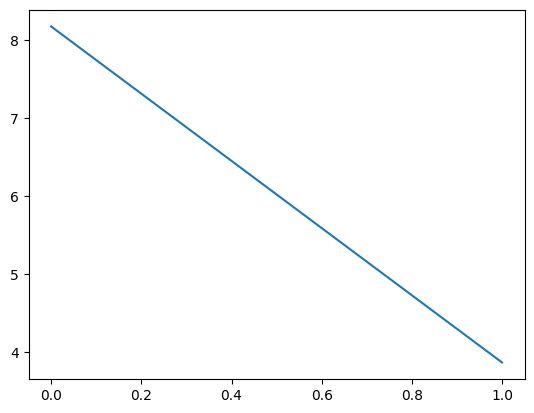

In [79]:
def train_epoch(model, optimizer, max_step=float("inf")):
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    bar = tqdm(train_dl, unit="batch")

    for step, data in enumerate(bar):
        optimizer.zero_grad()
        logits, scores = model(data[0], data[1])
        final_logits = torch.cat(logits, dim=0).view(
            logits[0].size(0), -1, logits[0].size(1)
        )
        loss = criterion(final_logits.transpose(1, 2), data[1])
        bar.set_postfix(**{"loss": loss.item()})

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # early exit, needed during development
        if step > max_step:
            break

    return total_loss / step


model = Seq2SeqEncoderDecoder(
    len(vocab),
    embedding_vector,
    300,
    vocab["<PAD>"],
    vocab["<SOS>"],
    vocab["<EOS>"],
    8,
    True,
)
optim = torch.optim.SGD(model.parameters(), lr=1.0)

losses = []
for i in range(1, 3):
    loss = train_epoch(model, optim, max_step=5)
    print("epoch", i, "loss", loss)
    losses.append(loss)

plt.plot(losses)

In [88]:
source = next(iter(train_dl))[0]
torch.concat(model.generate(source)[0], dim=0).view(source.size(0), -1).shape

torch.Size([32, 11])

[tensor([[   0, 1876,   23,  ...,    2,    2,    2],
         [   0,   11,    3,  ...,    2,    2,    2],
         [   0,    4,   69,  ...,    2,    2,    2],
         ...,
         [   0,  553,    5,  ...,    2,    2,    2],
         [   0,    4, 8442,  ...,    2,    2,    2],
         [   0,  670,    4,  ...,    2,    2,    2]]),
 tensor([[   0,  298,   17,  ...,    2,    2,    2],
         [   0, 3462,  239,  ...,    2,    2,    2],
         [   0,  733,   75,  ...,    2,    2,    2],
         ...,
         [   0,    9,  298,  ...,    2,    2,    2],
         [   0,   59, 2459,  ...,    2,    2,    2],
         [   0,  298, 6566,  ...,    2,    2,    2]])]